# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Seaborn style
sns.set_style("dark")

# Load Data

In [3]:
# Load games requirements table
games_requirement_data = pd.read_csv('../tables/games_requirement_data.csv', index_col=0)

# Load benchmark score table
benchmark_score_data = pd.read_csv('../tables/benchmark_score_data.csv', index_col=0)

# Load GPU table
gpu_data = pd.read_csv('../tables/gpu_data.csv', index_col=0)

# Load RAM table
ram_data = pd.read_csv('../tables/ram_data.csv', index_col=0)

# Handling Null Values

In [4]:
def null_values(df):
    for column in df.columns:
        null_count = df[column].isna().sum()
        if (null_count>0):
            print(f'{column}: {null_count} null values')    

In [5]:
null_values(games_requirement_data)

gpu_minimum_benchmark_score: 7 null values
gpu_recommended_benchmark_score: 2 null values


In [6]:
null_values(benchmark_score_data)

In [7]:
null_values(gpu_data)

benchmark_score: 6 null values


In [8]:
null_values(ram_data)

In [9]:
games_requirement_data.dropna(inplace=True)

# Filtering old games

Games released more than three years ago will not enter in the analysis

In [10]:
# Convert release date to date time
games_requirement_data['release_date'] = pd.to_datetime(games_requirement_data['release_date'], format='%Y. %B %d.')

# Filtering old games
games_requirement_data = games_requirement_data[games_requirement_data['release_date'].dt.year >= 2023]

# Extract only date from datetime object
games_requirement_data['release_date'] = games_requirement_data['release_date'].dt.date

# Most dominant NVIDIA GPU on Market

In [11]:
# Sort values by Market Share
gpu_data.sort_values('market_share', ascending=False, inplace=True)

# Filter GPU by its Market Share
most_dominant = gpu_data.head(5)
most_dominant['market_share'] = most_dominant['market_share'] * 100

C:\Users\pedro\AppData\Local\Temp\ipykernel_12636\2260296473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_dominant['market_share'] = most_dominant['market_share'] * 100


In [12]:
print(f"Market share of Most Dominant GPUs on Market {round(most_dominant['market_share'].sum(),2)}%")

Market share of Most Dominant GPUs on Market 39.07%


## Market Share of each GPU

C:\Users\pedro\AppData\Local\Temp\ipykernel_12636\357262228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


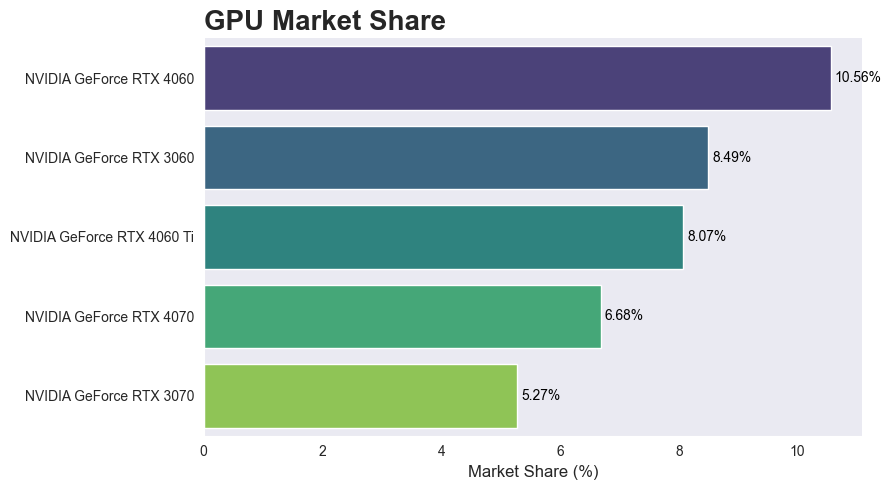

In [13]:
# Create the horizontal bar chart
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y=most_dominant['gpu_name'], 
    x=most_dominant['market_share'], 
    palette="viridis"
)

# Add values inside the bars (formatted as percentage)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10, color='black')

# Customize labels and title
plt.xlabel('Market Share (%)', fontsize=12)
plt.ylabel('')
plt.title('GPU Market Share', fontsize=20, fontweight='bold', loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

## How many games each GPU can run on Minimum and Recommended settings

In [14]:
# Function to calculate compatible games
def get_compatible_games(benchmark_score):
    compatible_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    compatible_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    return len(compatible_minimum), len(compatible_recommended)

# Collecting data for the chart
data = []

for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    min_count, rec_count = get_compatible_games(score)
    
    data.append({'GPU': gpu_name, 'Configuration': 'Minimum', 'Compatible Games': min_count})
    data.append({'GPU': gpu_name, 'Configuration': 'Recommended', 'Compatible Games': rec_count})

# Creating a DataFrame for Seaborn
df_plot = pd.DataFrame(data)

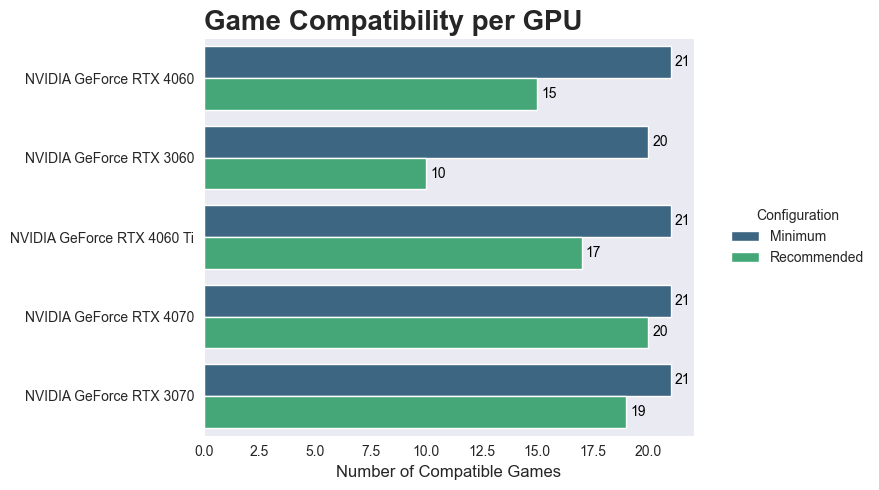

In [15]:
# Create the standardized horizontal bar plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y='GPU', 
    x='Compatible Games', 
    hue='Configuration', 
    data=df_plot, 
    palette="viridis",
    dodge=True
)

# Add values on bars (standardized formatting)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Standardized labels and title
plt.xlabel('Number of Compatible Games', fontsize=12)
plt.ylabel('')
plt.title('Game Compatibility per GPU', fontsize=20, fontweight='bold', loc='left')

# Remove unnecessary spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Standardized legend position and style
plt.legend(
    title='Configuration',
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc='center left',
    fontsize=10
)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

## How many games each GPU can't run on Recommended settings

In [16]:
# Função para calcular os jogos que rodam no mínimo, mas não no recomendado
def get_minimum_but_not_recommended(benchmark_score):
    # Jogos que rodam no mínimo
    games_able_to_run_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    
    # Jogos que rodam no recomendado
    games_able_to_run_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    
    # Filtrar jogos que rodam no mínimo, mas não no recomendado
    games_minimum_not_recommended = games_able_to_run_minimum[~games_able_to_run_minimum['game_name'].isin(games_able_to_run_recommended['game_name'])]
    
    return len(games_minimum_not_recommended)

# Coletando os dados para o gráfico
data = []

for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    count_not_recommended = get_minimum_but_not_recommended(score)
    data.append({'GPU': gpu_name, 'Games Not Recommended': count_not_recommended})

# Criando um DataFrame para o Seaborn
df_plot = pd.DataFrame(data)

C:\Users\pedro\AppData\Local\Temp\ipykernel_12636\3364397363.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


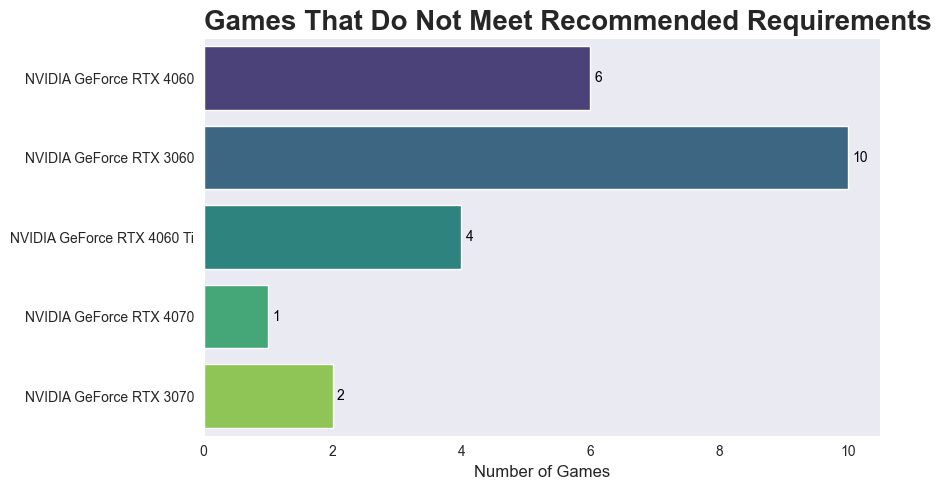

In [17]:
# Creating the standardized horizontal bar chart  
plt.figure(figsize=(9, 5))  
ax = sns.barplot(  
    y='GPU',   
    x='Games Not Recommended',   
    data=df_plot,   
    palette="viridis"  
)  

# Add values inside the bars  
for container in ax.containers:  
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')  

# Customize labels and title  
plt.xlabel('Number of Games', fontsize=12)  
plt.ylabel('')  
plt.title('Games That Do Not Meet Recommended Requirements', fontsize=20, fontweight='bold', loc='left')  

ax.spines['right'].set_visible(False)  
ax.spines['top'].set_visible(False)  

# Adjust layout  
plt.tight_layout()  

# Display the chart  
plt.show() 

## Wich game each GPU can't run on Recommended settings

In [18]:
# Function to calculate games that run on minimum but not recommended settings
def get_minimum_but_not_recommended(benchmark_score):
    # Games that can run on minimum settings
    games_able_to_run_minimum = games_requirement_data[games_requirement_data['gpu_minimum_benchmark_score'] <= benchmark_score]
    
    # Games that can run on recommended settings
    games_able_to_run_recommended = games_requirement_data[games_requirement_data['gpu_recommended_benchmark_score'] <= benchmark_score]
    
    # Filter games that run on minimum but not recommended settings
    games_minimum_not_recommended = games_able_to_run_minimum[~games_able_to_run_minimum['game_name'].isin(games_able_to_run_recommended['game_name'])]
    
    return games_minimum_not_recommended['game_name'].to_list(), games_minimum_not_recommended

# List to store games that don't meet recommended requirements for each GPU
all_games_not_recommended = []

# Iterate over each GPU and calculate games that run on minimum but not recommended settings
for gpu_name, score in zip(most_dominant['gpu_name'], most_dominant['benchmark_score']):
    games_list, games_not_recommended_df = get_minimum_but_not_recommended(score)
    
    # Print the results
    print(f"GPU: {gpu_name}")
    print(f"Games that run on Minimum but not Recommended: {games_list}\n")
    
    # Store the DataFrame for future analysis
    all_games_not_recommended.append(games_not_recommended_df)

# Concatenate all DataFrames of games that don't meet recommended requirements
all_games_not_recommended_data = pd.concat(all_games_not_recommended, ignore_index=True)

GPU: NVIDIA GeForce RTX 4060
Games that run on Minimum but not Recommended: ["Assassin's Creed Shadows", 'inZOI', 'Split Fiction', 'The Last of Us Part I', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 3060
Games that run on Minimum but not Recommended: ["Assassin's Creed Shadows", 'inZOI', 'Split Fiction', 'Monster Hunter Wilds', 'The Last of Us Part I', 'Farming Simulator 25', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'F1 24', 'God of War Ragnarök', 'Call of Duty: Black Ops 6']

GPU: NVIDIA GeForce RTX 4060 Ti
Games that run on Minimum but not Recommended: ['inZOI', 'Split Fiction', 'S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 4070
Games that run on Minimum but not Recommended: ['Indiana Jones and the Great Circle']

GPU: NVIDIA GeForce RTX 3070
Games that run on Minimum but not Recommended: ['S.T.A.L.K.E.R. 2: Heart of Chornobyl', 'Indiana Jones and the Great Circle']



In [19]:
high_requisite_games = all_games_not_recommended_data[['game_name', 'gpu_minimum_benchmark_score', 'gpu_recommended_benchmark_score']].value_counts().reset_index()
games_requirement_data.sort_values('gpu_recommended_benchmark_score', ascending=False, inplace=True)

C:\Users\pedro\AppData\Local\Temp\ipykernel_12636\2011683030.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="lower right")


<Figure size 900x500 with 0 Axes>

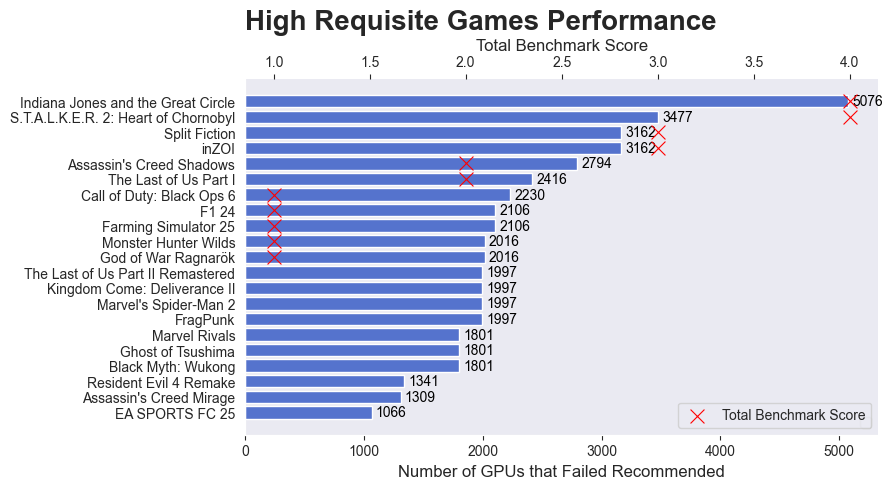

In [20]:
# Create figure and axes with standardized style
plt.figure(figsize=(9, 5))
fig, ax1 = plt.subplots(figsize=(9, 5))

# Main horizontal bar chart (standardized)
sns.barplot(
    y='game_name', 
    x='gpu_recommended_benchmark_score', 
    data=games_requirement_data, 
    ax=ax1, 
    color='royalblue'
)

# Add values on bars (standardized)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', padding=3, fontsize=10, color='black')

# Create secondary X-axis for benchmark scores
ax2 = ax1.twiny()
sns.scatterplot(
    y='game_name', 
    x='count', 
    data=high_requisite_games, 
    color='red', 
    marker='x', 
    s=100,  # Marker size
    ax=ax2, 
    label='Total Benchmark Score'
)

# Standardized customization
ax1.set_xlabel("Number of GPUs that Failed Recommended", fontsize=12)
ax1.set_ylabel("")  # Removing Y label for cleaner look
ax2.set_xlabel("Total Benchmark Score", fontsize=12)
plt.title("High Requisite Games Performance", fontsize=20, fontweight='bold', loc='left')

# Remove borders and grid (standardized)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(False)

# Adjusting legend to bottom right corner
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")

# Standardized layout adjustment
plt.tight_layout()

# Display the chart
plt.show()

# Most Powerful GPUs

In [21]:
# Sort values by Benchmark Score
gpu_data.sort_values('benchmark_score', ascending=False, inplace=True)

# Filter GPU by its Market Share
most_powerful = gpu_data.head()
most_powerful['market_share'] = most_powerful['market_share'] * 100

C:\Users\pedro\AppData\Local\Temp\ipykernel_12636\610699987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_powerful['market_share'] = most_powerful['market_share'] * 100


In [22]:
# Calculate Market Share for Poweful GPUs
print(f"Market share of Most Powerful GPUs on Market {round(most_powerful['market_share'].sum(),2)}%")

Market share of Most Powerful GPUs on Market 4.92%


# Wich Games are the easiest and the hardest to Run

In [23]:
games_requirement_data['benchmark_score'] = games_requirement_data['gpu_minimum_benchmark_score'] + games_requirement_data['gpu_recommended_benchmark_score']

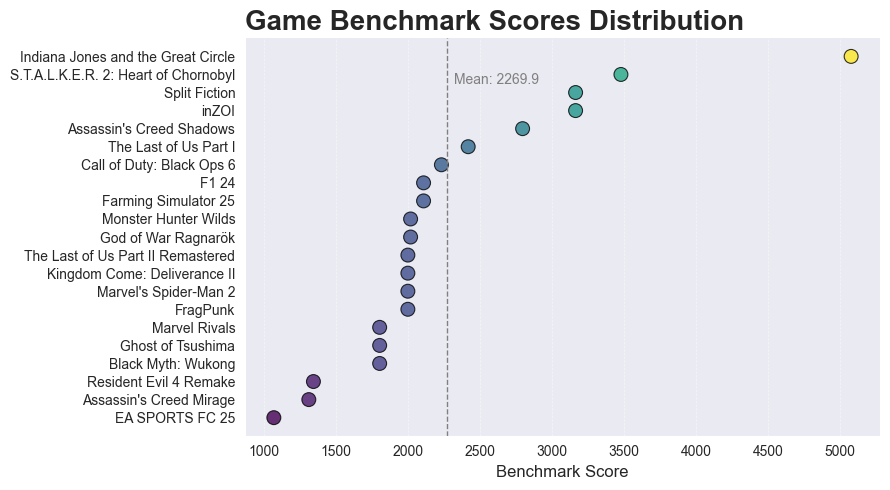

In [24]:
plt.figure(figsize=(9, 5))

# Create scatter plot with standardized style
scatter = sns.scatterplot(
    y='game_name',  # Changed to Y-axis to maintain horizontal standard
    x='gpu_recommended_benchmark_score',
    data=games_requirement_data,
    hue='gpu_recommended_benchmark_score',
    palette="viridis",  # Using default palette
    marker='o',
    edgecolor='black',
    alpha=0.8,
    s=100,
    legend=False  # Removing legend to simplify
)

# Add vertical reference line (adjusted for horizontal plot)
plt.axvline(x=games_requirement_data['gpu_recommended_benchmark_score'].mean(),
            color='gray', linestyle='dashed', linewidth=1)

# Standardized customization
plt.xlabel("Benchmark Score", fontsize=12)
plt.ylabel("")  # Removing Y label
plt.title("Game Benchmark Scores Distribution", fontsize=20, fontweight='bold', loc='left')

# Remove unnecessary borders
scatter.spines['right'].set_visible(False)
scatter.spines['top'].set_visible(False)

# Grid only on X-axis (main)
plt.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5)

# Adjust Y-axis label rotation
plt.yticks(fontsize=10)

# Add annotation for mean line
plt.annotate(f'Mean: {games_requirement_data["gpu_recommended_benchmark_score"].mean():.1f}',
             xy=(games_requirement_data['gpu_recommended_benchmark_score'].mean(), 0),
             xytext=(5, -20), textcoords='offset points',
             color='gray', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()